<a href="https://colab.research.google.com/github/Matvezy/Body-Mesurments/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [14]:
%cd /content/gdrive/MyDrive/AITrainingLibRandClothHair500Fix

/content/gdrive/MyDrive/AITrainingLibRandClothHair500Fix


In [122]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [124]:
class Transforms():
    def __init__(self):
        pass

    def crop_person(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[2], img_shape[1]])
        return image, landmarks
      
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image, landmarks = self.crop_person(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (354, 254))
        landmarks = landmarks * torch.tensor([[254, 354]])
        return image, landmarks

In [125]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('trainFront.xml')
        root = tree.getroot()
        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        for filename in root[1]:
            self.image_filenames.append(filename.attrib['file'])
            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(25):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = torch.load(self.image_filenames[index])
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])
            
        return image, landmarks

In [126]:
dataset = FaceLandmarksDataset(Transforms())

In [114]:
def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]

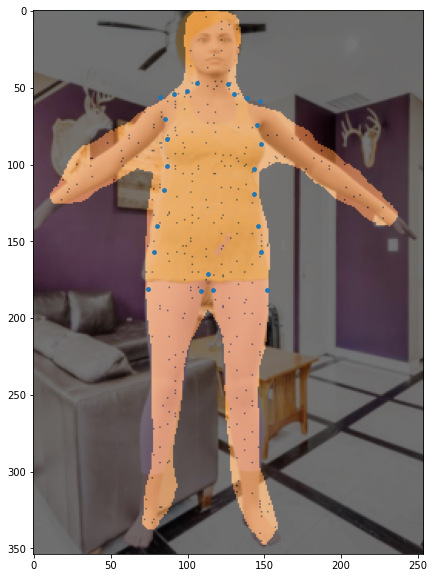

In [121]:
image, landmarks = dataset[2]
image = image.type(torch.float32).numpy()[0]
image1 = Image.open('/content/gdrive/MyDrive/AITrainingLibRandClothHair500Fix/AITrainingLib/3/Front.png')
image1 = TF.crop(image1, 132, 281, 851, 559)
image1 = TF.resize(image1, (354, 254))
image1 = np.asarray(image1)
if image1.shape[-1] == 4:
  image1 = image1[..., :3]
image = random_colour_masks(image)
masked = cv2.addWeighted(image1, 0.5, image, 0.5, 0)
plt.figure(figsize=(10, 10))
plt.imshow(masked);
plt.scatter(landmarks[:,0], landmarks[:,1], s=14);

In [127]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 422
The length of Valid set is 46


In [128]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 354, 254])
torch.Size([64, 25, 2])


In [129]:
class Network(nn.Module):
    def __init__(self,num_classes=50):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [130]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [131]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)

loss_min = np.inf
num_epochs = 400   
start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    #network = network.load_state_dict(torch.load('body_landmarks.pth')) 
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'body_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 6/6  Loss: 11490.3035 
--------------------------------------------------
Epoch: 1  Train Loss: 15188.8082  Valid Loss: 11490.3035
--------------------------------------------------

Minimum Validation Loss of 11490.3035 at epoch 1/400
Model Saved

Valid Steps: 6/6  Loss: 13249.7922 
--------------------------------------------------
Epoch: 2  Train Loss: 14289.3217  Valid Loss: 13249.7922
--------------------------------------------------
Valid Steps: 6/6  Loss: 11908.1966 
--------------------------------------------------
Epoch: 3  Train Loss: 13036.2433  Valid Loss: 11908.1966
--------------------------------------------------
Valid Steps: 6/6  Loss: 10771.6258 
--------------------------------------------------
Epoch: 4  Train Loss: 11763.6267  Valid Loss: 10771.6258
--------------------------------------------------

Minimum Validation Loss of 10771.6258 at epoch 4/400
Model Saved

Valid Steps: 6/6  Loss: 9397.8953 
--------------------------------------------------


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-7lq34jyf'


Valid Steps: 6/6  Loss: 6624.4110 
--------------------------------------------------
Epoch: 8  Train Loss: 7177.1891  Valid Loss: 6624.4110
--------------------------------------------------

Minimum Validation Loss of 6624.4110 at epoch 8/400
Model Saved

Valid Steps: 6/6  Loss: 5826.1380 
--------------------------------------------------
Epoch: 9  Train Loss: 6229.3579  Valid Loss: 5826.1380
--------------------------------------------------

Minimum Validation Loss of 5826.1380 at epoch 9/400
Model Saved

Valid Steps: 6/6  Loss: 4703.4801 
--------------------------------------------------
Epoch: 10  Train Loss: 5296.2222  Valid Loss: 4703.4801
--------------------------------------------------

Minimum Validation Loss of 4703.4801 at epoch 10/400
Model Saved

Valid Steps: 6/6  Loss: 3773.9503 
--------------------------------------------------
Epoch: 11  Train Loss: 4553.5555  Valid Loss: 3773.9503
--------------------------------------------------

Minimum Validation Loss of 377

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-vn7c2ibp'


Train Steps: 4/7  Loss: 388.4595 

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-or7g8dhc'


Valid Steps: 6/6  Loss: 274.4984 
--------------------------------------------------
Epoch: 23  Train Loss: 371.6388  Valid Loss: 274.4984
--------------------------------------------------

Minimum Validation Loss of 274.4984 at epoch 23/400
Model Saved

Valid Steps: 6/6  Loss: 203.3118 
--------------------------------------------------
Epoch: 24  Train Loss: 296.7236  Valid Loss: 203.3118
--------------------------------------------------

Minimum Validation Loss of 203.3118 at epoch 24/400
Model Saved

Valid Steps: 6/6  Loss: 196.9910 
--------------------------------------------------
Epoch: 25  Train Loss: 237.7215  Valid Loss: 196.9910
--------------------------------------------------

Minimum Validation Loss of 196.9910 at epoch 25/400
Model Saved

Valid Steps: 6/6  Loss: 154.2137 
--------------------------------------------------
Epoch: 26  Train Loss: 181.3190  Valid Loss: 154.2137
--------------------------------------------------

Minimum Validation Loss of 154.2137 at ep

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ldzn_k3m'


Valid Steps: 6/6  Loss: 76.5299 
--------------------------------------------------
Epoch: 54  Train Loss: 33.2296  Valid Loss: 76.5299
--------------------------------------------------
Valid Steps: 6/6  Loss: 36.5237 
--------------------------------------------------
Epoch: 55  Train Loss: 26.3165  Valid Loss: 36.5237
--------------------------------------------------
Valid Steps: 6/6  Loss: 55.9917 
--------------------------------------------------
Epoch: 56  Train Loss: 29.4708  Valid Loss: 55.9917
--------------------------------------------------
Valid Steps: 6/6  Loss: 37.1712 
--------------------------------------------------
Epoch: 57  Train Loss: 28.0762  Valid Loss: 37.1712
--------------------------------------------------
Valid Steps: 6/6  Loss: 36.1021 
--------------------------------------------------
Epoch: 58  Train Loss: 29.7720  Valid Loss: 36.1021
--------------------------------------------------
Valid Steps: 6/6  Loss: 30.7343 
--------------------------------

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-a0atr25d'


Valid Steps: 6/6  Loss: 32.5248 
--------------------------------------------------
Epoch: 60  Train Loss: 29.5734  Valid Loss: 32.5248
--------------------------------------------------
Valid Steps: 6/6  Loss: 47.1869 
--------------------------------------------------
Epoch: 61  Train Loss: 28.8193  Valid Loss: 47.1869
--------------------------------------------------
Valid Steps: 6/6  Loss: 47.6018 
--------------------------------------------------
Epoch: 62  Train Loss: 27.3056  Valid Loss: 47.6018
--------------------------------------------------
Valid Steps: 6/6  Loss: 52.5961 
--------------------------------------------------
Epoch: 63  Train Loss: 25.7970  Valid Loss: 52.5961
--------------------------------------------------
Valid Steps: 6/6  Loss: 97.5443 
--------------------------------------------------
Epoch: 64  Train Loss: 27.1610  Valid Loss: 97.5443
--------------------------------------------------
Valid Steps: 6/6  Loss: 23.0654 
--------------------------------

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-1c5ldjd2'


Valid Steps: 6/6  Loss: 59.4818 
--------------------------------------------------
Epoch: 70  Train Loss: 25.5894  Valid Loss: 59.4818
--------------------------------------------------
Valid Steps: 6/6  Loss: 58.2232 
--------------------------------------------------
Epoch: 71  Train Loss: 25.2396  Valid Loss: 58.2232
--------------------------------------------------
Valid Steps: 6/6  Loss: 35.7288 
--------------------------------------------------
Epoch: 72  Train Loss: 24.4902  Valid Loss: 35.7288
--------------------------------------------------
Valid Steps: 6/6  Loss: 35.4173 
--------------------------------------------------
Epoch: 73  Train Loss: 22.4971  Valid Loss: 35.4173
--------------------------------------------------
Valid Steps: 6/6  Loss: 47.8884 
--------------------------------------------------
Epoch: 74  Train Loss: 22.7169  Valid Loss: 47.8884
--------------------------------------------------
Valid Steps: 6/6  Loss: 41.7336 
--------------------------------

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-1alipho0'


Valid Steps: 6/6  Loss: 14.1441 
--------------------------------------------------
Epoch: 202  Train Loss: 5.5201  Valid Loss: 14.1441
--------------------------------------------------
Valid Steps: 6/6  Loss: 12.4737 
--------------------------------------------------
Epoch: 203  Train Loss: 5.2705  Valid Loss: 12.4737
--------------------------------------------------
Valid Steps: 6/6  Loss: 16.5859 
--------------------------------------------------
Epoch: 204  Train Loss: 5.3906  Valid Loss: 16.5859
--------------------------------------------------
Valid Steps: 6/6  Loss: 13.5110 
--------------------------------------------------
Epoch: 205  Train Loss: 5.6937  Valid Loss: 13.5110
--------------------------------------------------
Valid Steps: 6/6  Loss: 14.7182 
--------------------------------------------------
Epoch: 206  Train Loss: 5.6590  Valid Loss: 14.7182
--------------------------------------------------
Valid Steps: 6/6  Loss: 16.4818 
--------------------------------

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-42j5pbcc'


Valid Steps: 6/6  Loss: 13.5840 
--------------------------------------------------
Epoch: 217  Train Loss: 5.1603  Valid Loss: 13.5840
--------------------------------------------------
Valid Steps: 6/6  Loss: 18.7228 
--------------------------------------------------
Epoch: 218  Train Loss: 4.9017  Valid Loss: 18.7228
--------------------------------------------------
Valid Steps: 6/6  Loss: 17.7304 
--------------------------------------------------
Epoch: 219  Train Loss: 5.9117  Valid Loss: 17.7304
--------------------------------------------------
Valid Steps: 6/6  Loss: 15.4115 
--------------------------------------------------
Epoch: 220  Train Loss: 5.1943  Valid Loss: 15.4115
--------------------------------------------------
Valid Steps: 6/6  Loss: 14.7504 
--------------------------------------------------
Epoch: 221  Train Loss: 5.8454  Valid Loss: 14.7504
--------------------------------------------------
Valid Steps: 6/6  Loss: 12.0132 
--------------------------------

KeyboardInterrupt: ignored

# Testing

In [132]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person'
]

def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [138]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [179]:
img = Image.open('/content/gdrive/MyDrive/Female/S/2/Front.jpg')
transform = T.Compose([T.ToTensor()])
img = transform(img)
if img.size()[0] == 4:
  img = img[:3, ...] 
pred = model([img])
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu()
masks = masks.type(torch.float32).numpy()
labels = pred[0]['labels'].detach().numpy()
scores = pred[0]['scores'].detach().numpy()
indh = np.where(labels == 1)
needed = np.where(scores[indh] > 0.8)
mask = masks[needed][0]
boxes = pred[0]['boxes'].detach().numpy()
box = boxes[needed].astype('int')[0]
mask = mask[box[1]:box[3], box[0]:box[2]]
mask1 = random_colour_masks(mask)
mask1 = Image.fromarray(mask1)
mask1 = TF.resize(mask1, (354, 254))
mask1 = np.asarray(mask1)

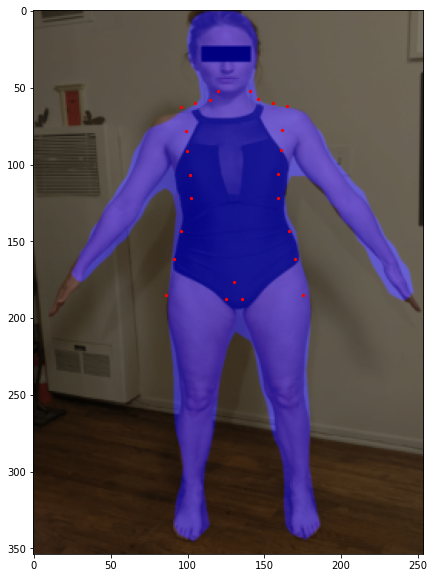

In [180]:
best_network = Network()
best_network.cuda()
best_network.load_state_dict(torch.load('body_landmarks.pth')) 
transform = T.Compose([T.ToTensor()])
mask = transform(mask)
mask = TF.resize(mask, (354, 254))
mask = mask.cuda()

predictions = (best_network(mask[None,...]).cpu())
predictions = predictions.view(-1,25,2)
predictions = predictions.detach().numpy()
    
#plt.figure(figsize=(10,40))
    
#plt.imshow(mask.cpu().detach().numpy().transpose(1,2,0).squeeze(), cmap='gray')

image1 = Image.open('/content/gdrive/MyDrive/Female/S/2/Front.jpg')
image1 = TF.crop(image1, box[1], box[0], box[3] - box[1], box[2] - box[0])
image1 = TF.resize(image1, (354, 254))
image1 = np.asarray(image1)

if image1.shape[-1] == 4:
  image1 = image1[..., :3]
masked = cv2.addWeighted(image1, 0.5, mask1, 0.5, 0)
plt.figure(figsize=(10, 10))
plt.imshow(masked);
plt.scatter(predictions[0,:,0], predictions[0,:,1], c = 'r', s = 5)